In [105]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [83]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
CHANNELS = 3 #RGB 
EPOCHS = 40

In [84]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Load data into tf Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 6727 files belonging to 11 classes.


In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Rice__bacterial_leaf_blight',
 'Rice__brown_spot',
 'Rice__healthy',
 'Rice__leaf_blast',
 'Rice__leaf_scald',
 'Rice__narrow_brown_spot']

In [5]:
len(dataset)

106

In [28]:
for image_batch, label_batch in dataset.take(1):
    
    print(image_batch[0].shape)
    print(image_batch[0].numpy())
    

(256, 256, 3)
[[[238.      233.      227.     ]
  [237.      232.      226.     ]
  [237.      232.      226.     ]
  ...
  [238.      231.      225.     ]
  [240.      233.      227.     ]
  [239.      232.      226.     ]]

 [[239.      234.      228.     ]
  [239.      234.      228.     ]
  [238.875   233.875   227.875  ]
  ...
  [237.23438 230.23438 224.23438]
  [239.125   232.125   226.125  ]
  [239.      232.      226.     ]]

 [[238.875   233.875   227.875  ]
  [238.875   233.875   227.875  ]
  [238.79688 233.76562 227.76562]
  ...
  [237.48438 230.48438 224.48438]
  [239.23438 232.23438 226.23438]
  [239.      232.      226.     ]]

 ...

 [[237.32812 227.20312 218.57812]
  [236.10938 225.98438 217.35938]
  [235.09375 224.85938 216.5625 ]
  ...
  [236.34375 225.125   219.125  ]
  [235.5     224.25    218.25   ]
  [235.125   223.875   217.875  ]]

 [[235.375   225.375   216.375  ]
  [234.89062 224.89062 215.89062]
  [232.875   222.75    214.125  ]
  ...
  [233.35938 222.10938 2

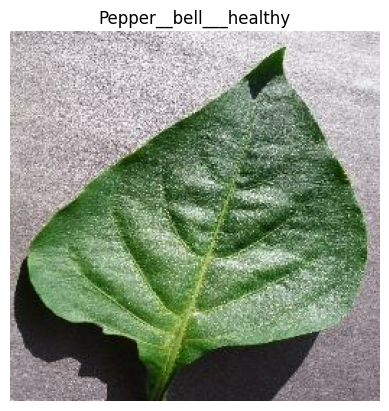

In [6]:
for image_batch, label_batch in dataset.take(1):

    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")                                             

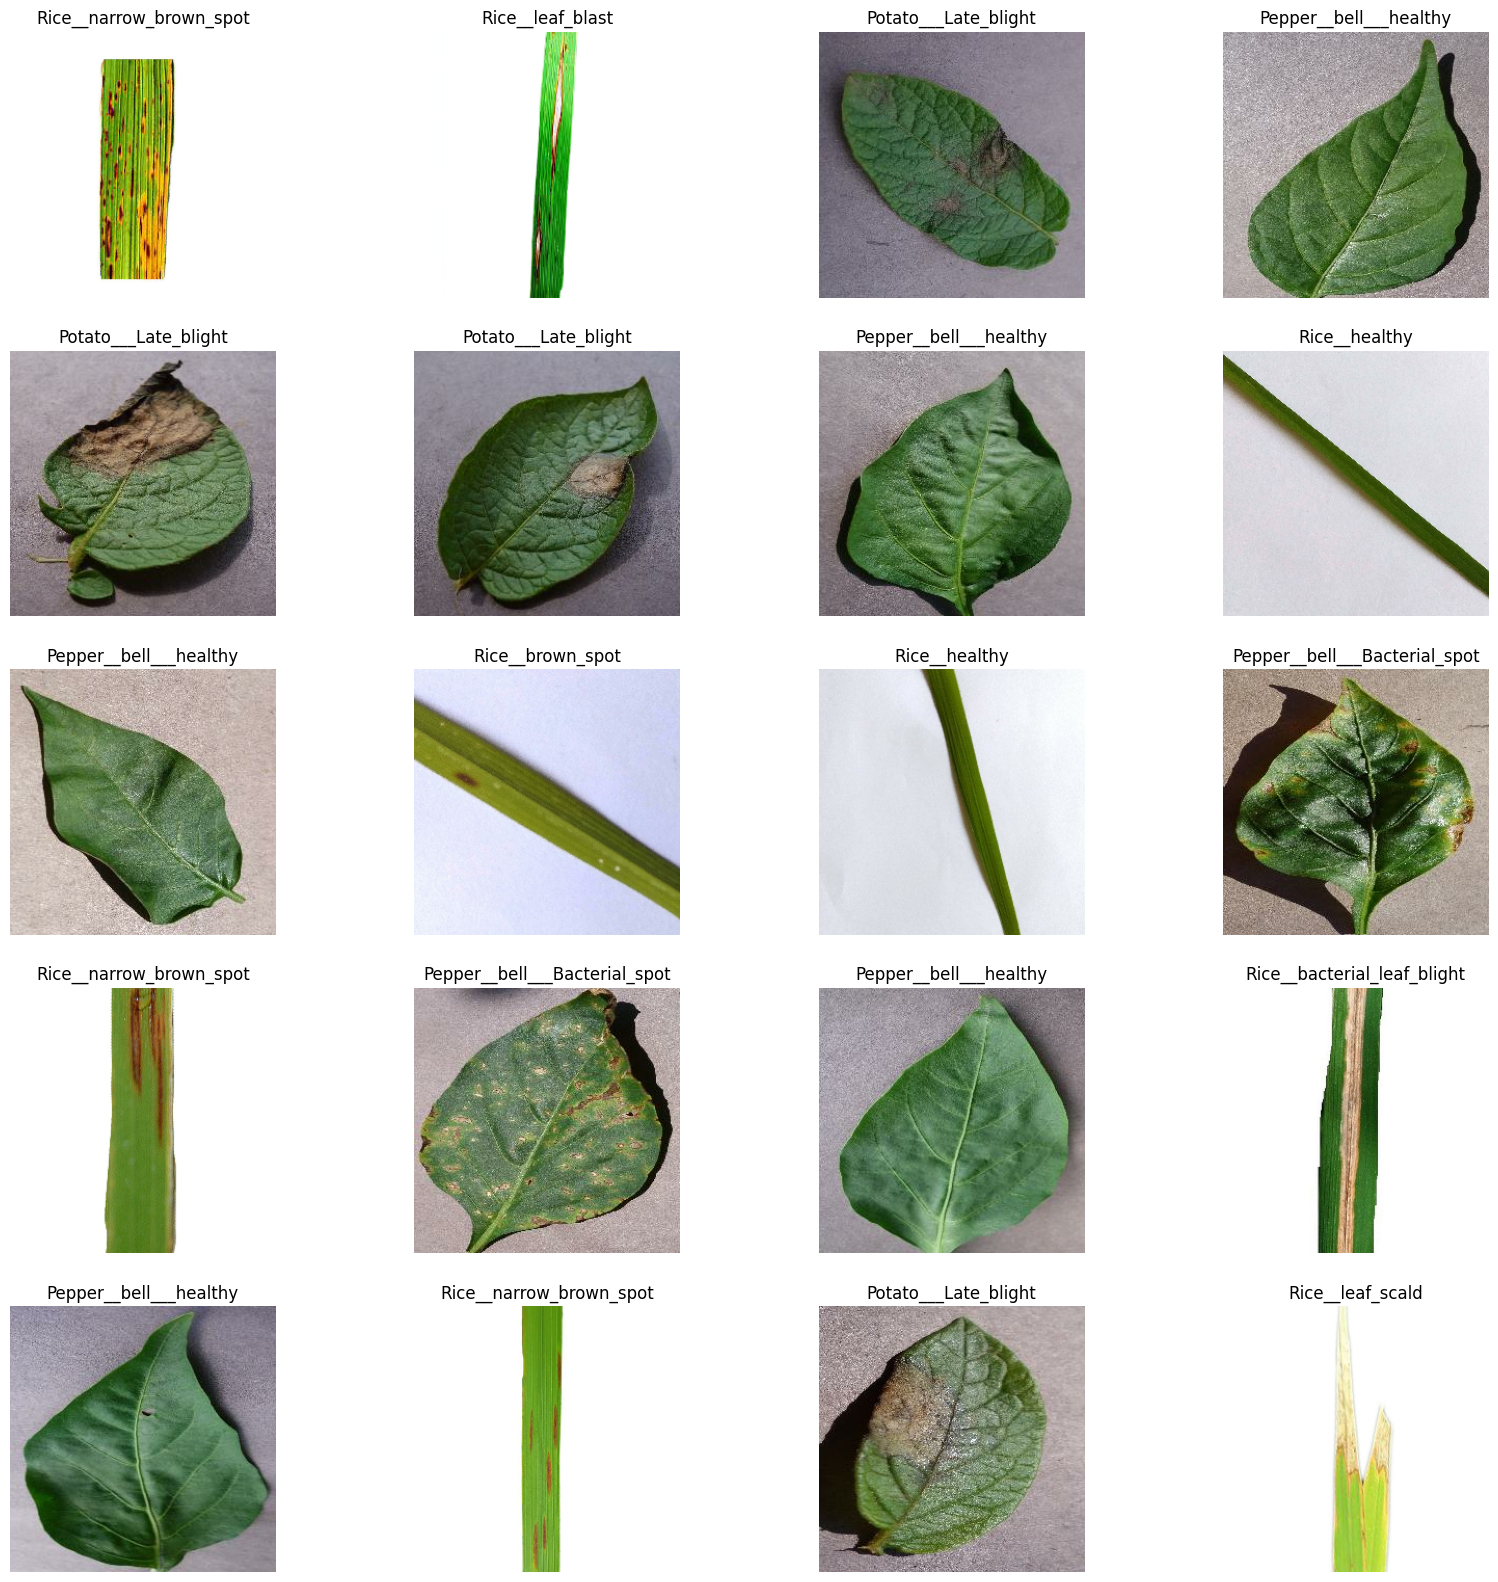

In [9]:
# Data Visualization
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(1):
    for i in range (20):
        plt.subplot(5,4,i+1) 
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
# Split the dataset into Train Test & Split
# 80% ==> training
# 20% ==> 10% validation, 10% test 

In [11]:
len(dataset)


106

In [12]:
# train_size = 0.8
# len(dataset)*train_size


In [13]:
# train_ds = dataset.take(258) #arr[:54]
# len(train_ds)

In [14]:
# test_ds = dataset.skip(258) #arr[54:]
# len(test_ds)

In [15]:
# validation_size = 0.1
# len(dataset)*validation_size

In [16]:
# validation_ds = test_ds.take(32)
# len(validation_ds)

In [17]:
# test_ds = test_ds.skip(32)
# len(test_ds)

In [8]:
# Train,Test & Split Function
def get_dataset_partitions_tf(ds, train_split= 0.8, validation_split=0.1, test_split=0.1, shuffle= True, shuffle_size=10000):
    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    validation_size = int(validation_split * ds_size)

    train_ds = ds.take(train_size)
    
    validation_ds = ds.skip(train_size).take(validation_size)
    
    test_ds = ds.skip(train_size).skip(validation_size)
    
    return train_ds, validation_ds, test_ds  


In [9]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(dataset) #calling the function

In [10]:
len(train_ds)

84

In [11]:
len(validation_ds)

10

In [12]:
len(test_ds)

12

In [13]:
# Cache & Prefetch Data
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
# Image Preprocessing
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)  
])    

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [75]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense

In [76]:
from tensorflow.keras.regularizers import l2

In [77]:
from sklearn.svm import SVC

In [79]:
# Model Building
input_shape= (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 11          
model = models.Sequential([
    
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(rate = 0.5),
    layers.Dense(n_classes, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='softmax'),
       
])
model.build(input_shape=input_shape)


In [80]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [81]:
model.summary()


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (64, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (64, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (64, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_102               │ (64, 127, 127, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (64, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_103               │ (64, 62, 62, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (64, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_104               │ (64, 30, 30, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (64, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_105               │ (64, 14, 14, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (64, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_106               │ (64, 6, 6, 64)         │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (64, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (64, 2, 2, 64)         │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (64, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (64, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (64, 11)               │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,267 (719.79 KB)

 Trainable params: 184,267 (719.79 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
history = model.fit( 
    train_ds, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE, 
    verbose = 1, 
    validation_data = validation_ds 
)

Epoch 1/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.2062 - loss: 2.3510 - val_accuracy: 0.3766 - val_loss: 1.7335
Epoch 2/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.3890 - loss: 1.6999 - val_accuracy: 0.5312 - val_loss: 1.3126
Epoch 3/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.5045 - loss: 1.3836 - val_accuracy: 0.5844 - val_loss: 1.2041
Epoch 4/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.6017 - loss: 1.1671 - val_accuracy: 0.7109 - val_loss: 0.9039
Epoch 5/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.6579 - loss: 1.0180 - val_accuracy: 0.7078 - val_loss: 0.8965
Epoch 6/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.6981 - loss: 0.9216 - val_accuracy: 0.7734 - val_loss: 0.7055
Epoch 7/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.7595 - loss: 0.7520 - val_accuracy: 0.7250 - val_loss: 0.7394
Epoch 8/40
84/84 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.7634 - loss: 0.7684 - val_accuracy: 0.7812 - v

In [86]:
scores = model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 808ms/step - accuracy: 0.9558 - loss: 0.1444


In [97]:
scores

[0.13614390790462494, 0.9622395634651184]

In [90]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 84}

In [91]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

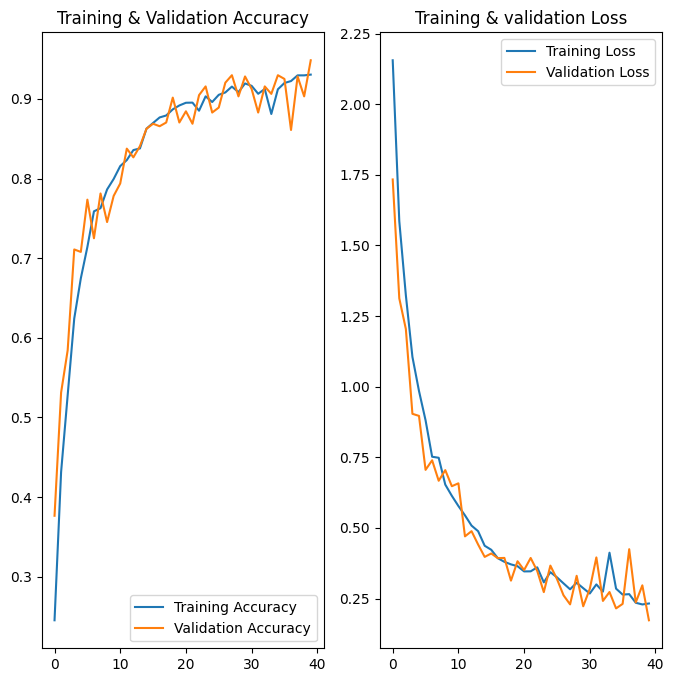

In [93]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label ='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label ='Validation Accuracy')
plt.legend(loc ='lower right')
plt.title('Training & Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & validation Loss')
plt.show()

First Image to predict
First Image actual label: Rice__leaf_scald
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
Rice__bacterial_leaf_blight


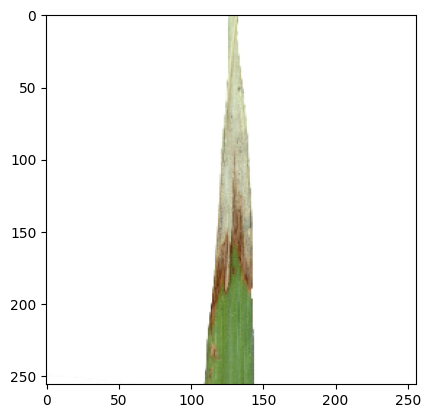

In [94]:

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    print("First Image to predict")
    plt.imshow(first_image)
    print("First Image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [95]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch

    predictions= model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


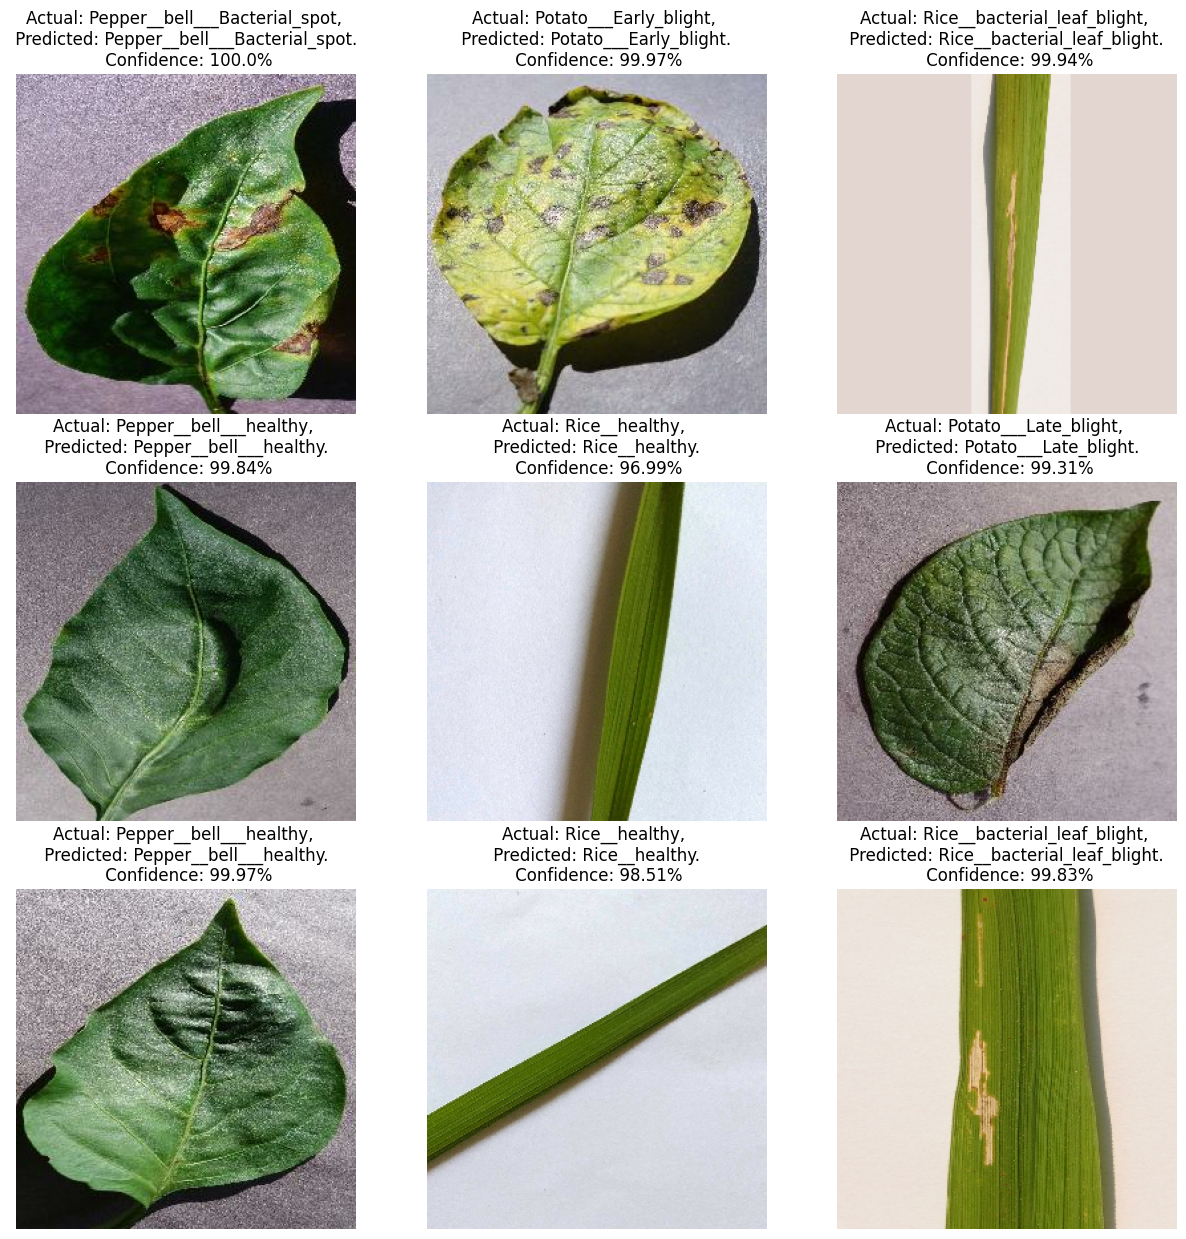

In [96]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        plt.axis("off")


In [115]:
model.save('my_model.keras')

In [122]:
model.save_weights('Plants.weights.h5')

In [99]:
os.path.join('models', '1.h5')

'models\\1.h5'